# Importing Libraries

In [ ]:
import os
import glob
import time
import numpy as np
from PIL import Image
from pathlib import Path
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from skimage.color import rgb2lab, lab2rgb
from os.path import exists

import torch
from torch import nn, optim
from torchvision import transforms
from torchvision.utils import make_grid
from torch.utils.data import Dataset, DataLoader
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Downloading Coco Dataset

In [ ]:
from fastai.data.external import untar_data, URLs
coco_path = untar_data(URLs.COCO_SAMPLE)
coco_path = str(coco_path) + "/train_sample"

In [ ]:
path = coco_path
paths = glob.glob(path + "/*.jpg")
np.random.seed(123)
paths_subset = np.random.choice(paths, 10_000, replace=False)
rand_idxs = np.random.permutation(10_000)
train_idxs = rand_idxs[:8000]
val_idxs = rand_idxs[8000:]
train_paths = paths_subset[train_idxs]
val_paths = paths_subset[val_idxs]
print(len(train_paths), len(val_paths))

8000 2000


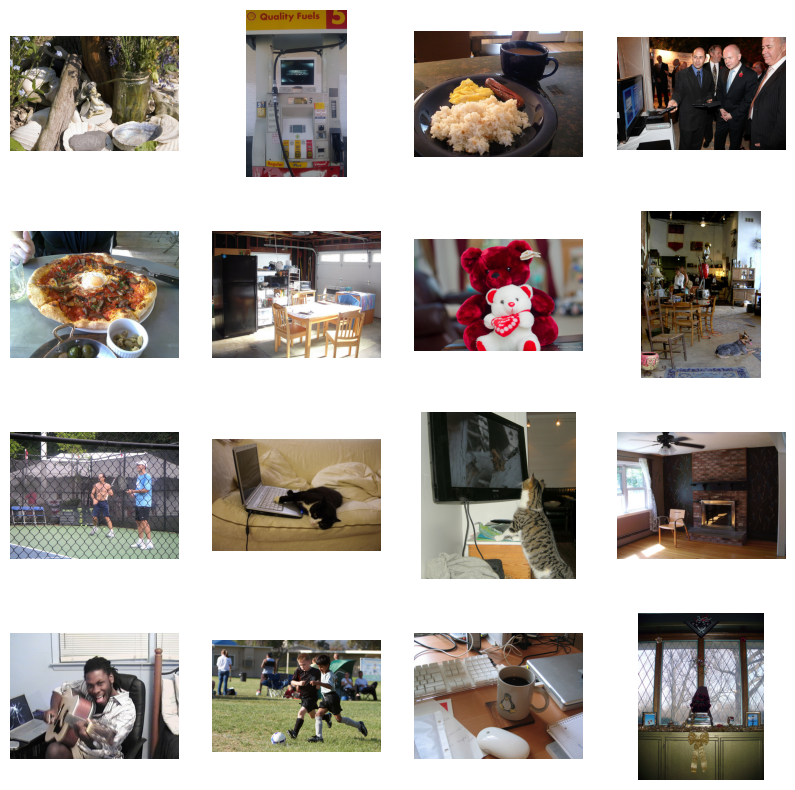

In [ ]:
_, axes = plt.subplots(4, 4, figsize=(10, 10))
for ax, img_path in zip(axes.flatten(), train_paths):
    ax.imshow(Image.open(img_path))
    ax.axis("off")

# Making Datasets and DataLoaders

In [ ]:
SIZE = 256
class ColorizationDataset(Dataset):
    def __init__(self, paths, split='train'):
        if split == 'train':
            self.transforms = transforms.Compose([
                transforms.Resize((SIZE, SIZE),  Image.BICUBIC),
                transforms.RandomHorizontalFlip(),
            ])
        elif split == 'val':
            self.transforms = transforms.Resize((SIZE, SIZE),  Image.BICUBIC)

        self.split = split
        self.size = SIZE
        self.paths = paths

    def __getitem__(self, idx):
        img = Image.open(self.paths[idx]).convert("RGB")
        img = self.transforms(img)
        img = np.array(img)
        img_lab = rgb2lab(img).astype("float32")
        img_lab = transforms.ToTensor()(img_lab)
        L = img_lab[[0], ...] / 50. - 1.
        ab = img_lab[[1, 2], ...] / 110.

        return {'L': L, 'ab': ab}

    def __len__(self):
        return len(self.paths)

def make_dataloaders(batch_size=16, n_workers=2, pin_memory=True, **kwargs):
    dataset = ColorizationDataset(**kwargs)
    dataloader = DataLoader(dataset, batch_size=batch_size, num_workers=n_workers,
                            pin_memory=pin_memory)
    return dataloader

In [ ]:
train_dl = make_dataloaders(paths=train_paths, split='train')
val_dl = make_dataloaders(paths=val_paths, split='val')

data = next(iter(train_dl))
Ls, abs_ = data['L'], data['ab']
print(Ls.shape, abs_.shape)
print(len(train_dl), len(val_dl))

torch.Size([16, 1, 256, 256]) torch.Size([16, 2, 256, 256])
500 125


# Utility

In [ ]:
class AverageMeter:
    def __init__(self):
        self.reset()

    def reset(self):
        self.count, self.avg, self.sum = [0.] * 3

    def update(self, val, count=1):
        self.count += count
        self.sum += count * val
        self.avg = self.sum / self.count

def create_loss_meters():
    loss_D_fake = AverageMeter()
    loss_D_real = AverageMeter()
    loss_D = AverageMeter()
    loss_G_GAN = AverageMeter()
    loss_G_L1 = AverageMeter()
    loss_G = AverageMeter()

    return {'loss_D_fake': loss_D_fake,
            'loss_D_real': loss_D_real,
            'loss_D': loss_D,
            'loss_G_GAN': loss_G_GAN,
            'loss_G_L1': loss_G_L1,
            'loss_G': loss_G}

def update_losses(model, loss_meter_dict, count):
    for loss_name, loss_meter in loss_meter_dict.items():
        loss = getattr(model, loss_name)
        loss_meter.update(loss.item(), count=count)

def lab_to_rgb(L, ab):
    """
    Takes a batch of images
    """

    L = (L + 1.) * 50.
    ab = ab * 110.
    Lab = torch.cat([L, ab], dim=1).permute(0, 2, 3, 1).cpu().numpy()
    rgb_imgs = []
    for img in Lab:
        img_rgb = lab2rgb(img)
        rgb_imgs.append(img_rgb)
    return np.stack(rgb_imgs, axis=0)

def visualize(model, data, save=True):
    model.net_G.eval()
    with torch.no_grad():
        model.setup_input(data)
        model.forward()
    model.net_G.train()
    fake_color = model.fake_color.detach()
    real_color = model.ab
    L = model.L
    fake_imgs = lab_to_rgb(L, fake_color)
    real_imgs = lab_to_rgb(L, real_color)
    fig = plt.figure(figsize=(15, 8))
    for i in range(5):
        ax = plt.subplot(3, 5, i + 1)
        ax.imshow(L[i][0].cpu(), cmap='gray')
        ax.axis("off")
        ax = plt.subplot(3, 5, i + 1 + 5)
        ax.imshow(fake_imgs[i])
        ax.axis("off")
        ax = plt.subplot(3, 5, i + 1 + 10)
        ax.imshow(real_imgs[i])
        ax.axis("off")
    plt.show()
    if save:
        fig.savefig(f"colorization_{time.time()}.png")

def log_results(loss_meter_dict):
    for loss_name, loss_meter in loss_meter_dict.items():
        print(f"{loss_name}: {loss_meter.avg:.5f}")

# Generator

In [ ]:
from fastai.vision.learner import create_body
from torchvision.models.resnet import resnet18
from fastai.vision.models.unet import DynamicUnet

In [ ]:
def build_res_unet(n_input=1, n_output=2, size=256):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = resnet18(weights='DEFAULT')
    body = create_body(model, pretrained=True, n_in=n_input, cut=-2)
    net_G = DynamicUnet(body, n_output, (size, size)).to(device)
    return net_G

# Pretraining the generator

In [ ]:
def pretrain_generator(net_G, train_dl, opt, criterion, epochs):
    for e in range(epochs):
        loss_meter = AverageMeter()
        for data in tqdm(train_dl):
            L, ab = data['L'].to(device), data['ab'].to(device)
            preds = net_G(L)
            loss = criterion(preds, ab)
            opt.zero_grad()
            loss.backward()
            opt.step()

            loss_meter.update(loss.item(), L.size(0))

        print(f"Epoch {e + 1}/{epochs}")
        print(f"L1 Loss: {loss_meter.avg:.5f}")

In [ ]:
net_G = build_res_unet(n_input=1, n_output=2, size=256)
if exists("res18_unet.pt"):
    net_G.load_state_dict(torch.load("res18_unet.pt", map_location=device))
    print("Loaded Old Generated.")
opt = optim.Adam(net_G.parameters(), lr=1e-4)
criterion = nn.L1Loss()
pretrain_generator(net_G, train_dl, opt, criterion, 2)
torch.save(net_G.state_dict(), "res18_unet.pt")

Loaded Old Generated.


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 1/2
L1 Loss: 0.07101


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 2/2
L1 Loss: 0.06765


# Discriminator

In [ ]:
class PatchDiscriminator(nn.Module):
    def __init__(self, input_c, num_filters=64, n_down=3):
        super().__init__()
        model = [self.get_layers(input_c, num_filters, norm=False)]
        model += [self.get_layers(num_filters * 2 ** i, num_filters * 2 ** (i + 1), s=1 if i == (n_down-1) else 2)
                          for i in range(n_down)]
        model += [self.get_layers(num_filters * 2 ** n_down, 1, s=1, norm=False, act=False)]
        self.model = nn.Sequential(*model)

    def get_layers(self, ni, nf, k=4, s=2, p=1, norm=True, act=True):
        layers = [nn.Conv2d(ni, nf, k, s, p, bias=not norm)]
        if norm: layers += [nn.BatchNorm2d(nf)]
        if act: layers += [nn.LeakyReLU(0.2, True)]
        return nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

In [ ]:
discriminator = PatchDiscriminator(3)
dummy_input = torch.randn(16, 3, 256, 256)
out = discriminator(dummy_input)
out.shape

torch.Size([16, 1, 30, 30])

# GAN Loss

In [ ]:
class GANLoss(nn.Module):
    def __init__(self, real_label=1.0, fake_label=0.0):
        super().__init__()
        self.register_buffer('real_label', torch.tensor(real_label))
        self.register_buffer('fake_label', torch.tensor(fake_label))
        self.loss = nn.BCEWithLogitsLoss()

    def get_labels(self, preds, target_is_real):
        if target_is_real:
            labels = self.real_label
        else:
            labels = self.fake_label
        return labels.expand_as(preds)

    def __call__(self, preds, target_is_real):
        labels = self.get_labels(preds, target_is_real)
        loss = self.loss(preds, labels)
        return loss

# Model Initialization

In [ ]:
def init_weights(net, gain=0.02):

    def init_func(m):
        classname = m.__class__.__name__
        if hasattr(m, 'weight') and 'Conv' in classname:
            nn.init.normal_(m.weight.data, mean=0.0, std=gain)

            if hasattr(m, 'bias') and m.bias is not None:
                nn.init.constant_(m.bias.data, 0.0)
        elif 'BatchNorm2d' in classname:
            nn.init.normal_(m.weight.data, 1., gain)
            nn.init.constant_(m.bias.data, 0.)

    net.apply(init_func)
    return net

def init_model(model, device):
    model = model.to(device)
    model = init_weights(model)
    return model

# Main Model

In [ ]:
class MainModel(nn.Module):
    def __init__(self, net_G=None, lr_G=2e-4, lr_D=2e-4,
                 beta1=0.5, beta2=0.999, lambda_L1=100.):
        super().__init__()

        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.lambda_L1 = lambda_L1
        self.net_G = net_G.to(self.device)

        self.net_D = init_model(PatchDiscriminator(input_c=3, n_down=3, num_filters=64), self.device)
        self.GANcriterion = GANLoss().to(self.device)
        self.L1criterion = nn.L1Loss()
        self.opt_G = optim.Adam(self.net_G.parameters(), lr=lr_G, betas=(beta1, beta2))
        self.opt_D = optim.Adam(self.net_D.parameters(), lr=lr_D, betas=(beta1, beta2))

    def set_requires_grad(self, model, requires_grad=True):
        for p in model.parameters():
            p.requires_grad = requires_grad

    def setup_input(self, data):
        self.L = data['L'].to(self.device)
        self.ab = data['ab'].to(self.device)

    def forward(self):
        self.fake_color = self.net_G(self.L)

    def backward_D(self):
        fake_image = torch.cat([self.L, self.fake_color], dim=1)
        fake_preds = self.net_D(fake_image.detach())
        self.loss_D_fake = self.GANcriterion(fake_preds, False)
        real_image = torch.cat([self.L, self.ab], dim=1)
        real_preds = self.net_D(real_image)
        self.loss_D_real = self.GANcriterion(real_preds, True)
        self.loss_D = (self.loss_D_fake + self.loss_D_real) * 0.5
        self.loss_D.backward()

    def backward_G(self):
        fake_image = torch.cat([self.L, self.fake_color], dim=1)
        fake_preds = self.net_D(fake_image)
        self.loss_G_GAN = self.GANcriterion(fake_preds, True)
        self.loss_G_L1 = self.L1criterion(self.fake_color, self.ab) * self.lambda_L1
        self.loss_G = self.loss_G_GAN + self.loss_G_L1
        self.loss_G.backward()

    def optimize(self):
        self.forward()
        self.net_D.train()
        self.set_requires_grad(self.net_D, True)
        self.opt_D.zero_grad()
        self.backward_D()
        self.opt_D.step()

        self.net_G.train()
        self.set_requires_grad(self.net_D, False)
        self.opt_G.zero_grad()
        self.backward_G()
        self.opt_G.step()

# Training function

In [ ]:
def train_model(model, train_dl, epochs, display_every=200):
    data = next(iter(val_dl))
    for e in range(epochs):
        loss_meter_dict = create_loss_meters()
        i = 0
        for data in tqdm(train_dl):
            model.setup_input(data)
            model.optimize()
            update_losses(model, loss_meter_dict, count=data['L'].size(0))
            i += 1
            if i % display_every == 0:
                print(f"\nEpoch {e+1}/{epochs}")
                print(f"Iteration {i}/{len(train_dl)}")
                log_results(loss_meter_dict)
                visualize(model, data, save=False)

# Train Model

Loaded Old Model.


  0%|          | 0/500 [00:00<?, ?it/s]


Epoch 1/2
Iteration 200/500
loss_D_fake: 0.60491
loss_D_real: 0.61767
loss_D: 0.61129
loss_G_GAN: 0.99508
loss_G_L1: 7.08224
loss_G: 8.07731


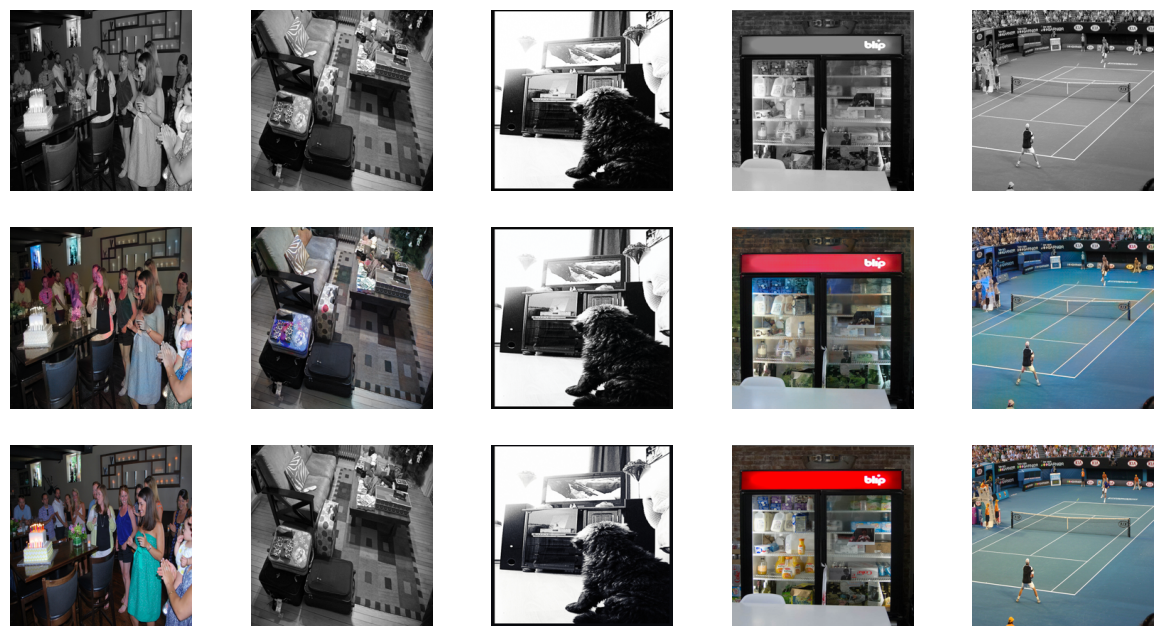


Epoch 1/2
Iteration 400/500
loss_D_fake: 0.60552
loss_D_real: 0.61824
loss_D: 0.61188
loss_G_GAN: 0.99993
loss_G_L1: 7.14406
loss_G: 8.14399


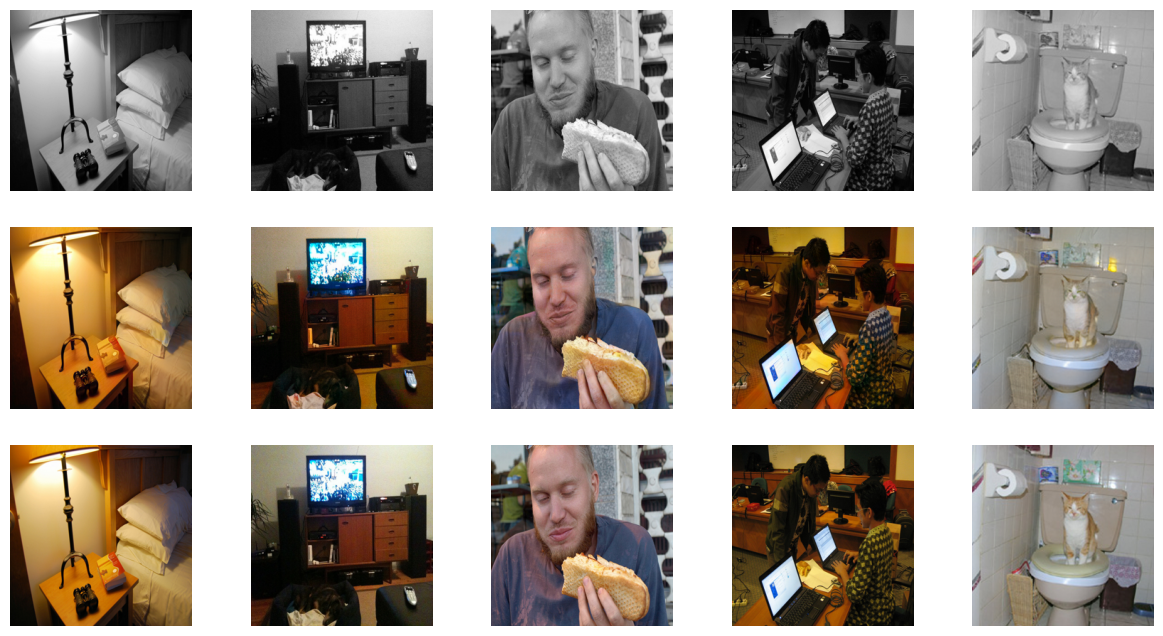

  0%|          | 0/500 [00:00<?, ?it/s]


Epoch 2/2
Iteration 200/500
loss_D_fake: 0.61408
loss_D_real: 0.62500
loss_D: 0.61954
loss_G_GAN: 0.95758
loss_G_L1: 6.48190
loss_G: 7.43948


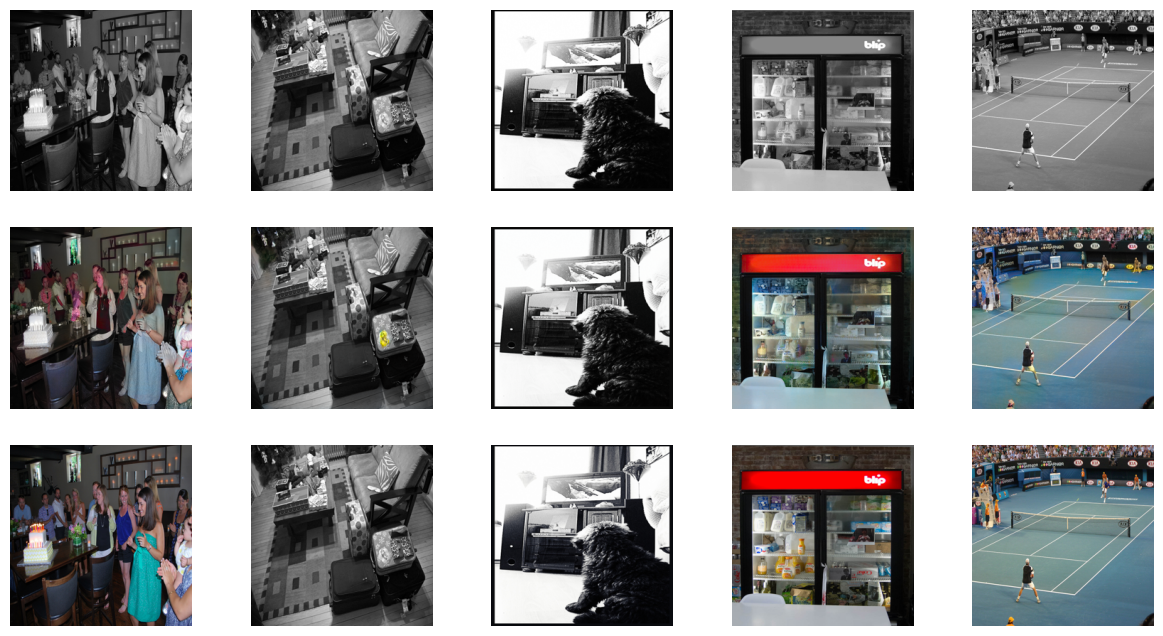


Epoch 2/2
Iteration 400/500
loss_D_fake: 0.61579
loss_D_real: 0.62579
loss_D: 0.62079
loss_G_GAN: 0.96389
loss_G_L1: 6.47198
loss_G: 7.43587


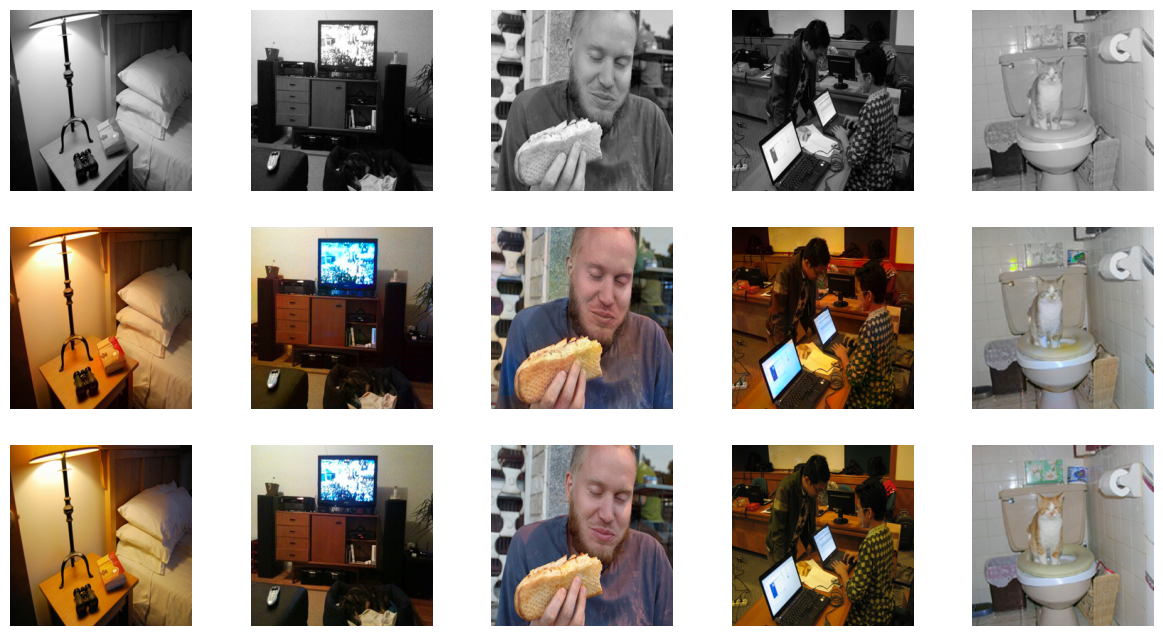

In [ ]:
net_G = build_res_unet(n_input=1, n_output=2, size=256)
net_G.load_state_dict(torch.load("res18_unet.pt", map_location=device))
model = MainModel(net_G=net_G)
if exists("image_colorization.pt"):
    model.load_state_dict(torch.load("image_colorization.pt", map_location=device))
    print("Loaded Old Model.")
train_model(model, train_dl, 2)
torch.save(model.state_dict(), "image_colorization.pt")

# Working Model

In [ ]:
!pip install -U gdown
!gdown 1y1iPCR8QQl2hlqxxK7UbJw4WX-RtcjGp # res18_unet.pt
!gdown 1r9VKHUuFfYJHhpQk7N_iZZxOHdICiKGT # image_colorization.pt

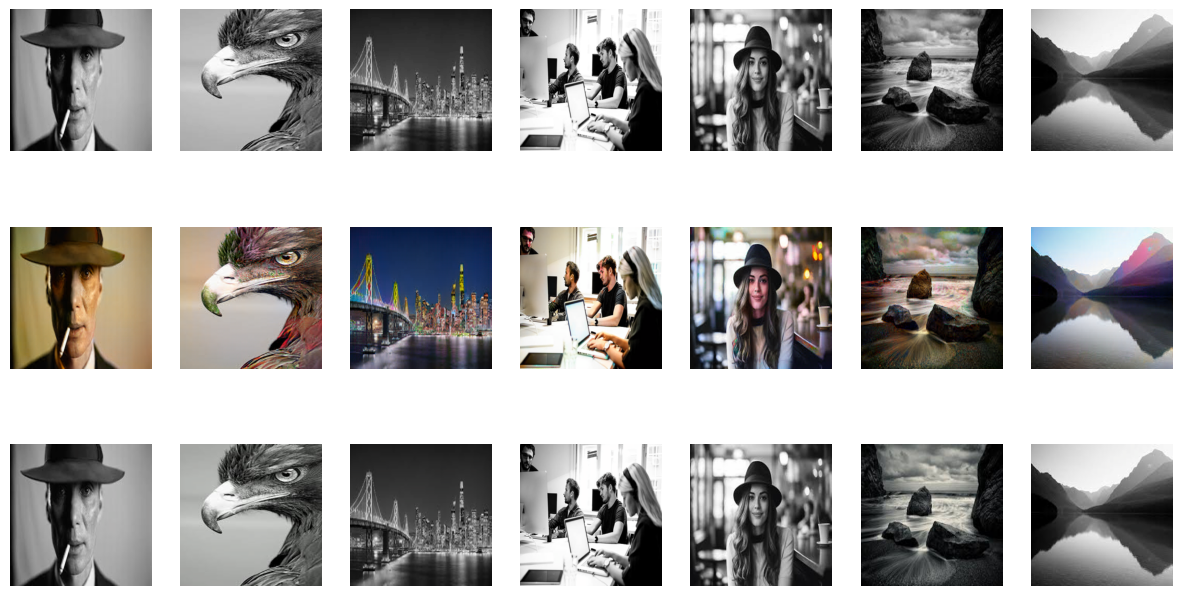

In [ ]:
net_G = build_res_unet(n_input=1, n_output=2, size=256)
net_G.load_state_dict(torch.load("res18_unet.pt", map_location=device))
model = MainModel(net_G=net_G)
model.load_state_dict(torch.load("image_colorization.pt", map_location=device))
image_paths=["Pics/"+i for i in os.listdir("Pics") if i != ".ipynb_checkpoints"]
data_dl = make_dataloaders(paths=image_paths, split='val')
data = next(iter(data_dl))

model.net_G.eval()
with torch.no_grad():
    model.setup_input(data)
    model.forward()
model.net_G.train()
fake_color = model.fake_color.detach()
real_color = model.ab
L = model.L
fake_imgs = lab_to_rgb(L, fake_color)
real_imgs = lab_to_rgb(L, real_color)
fig = plt.figure(figsize=(15, 8))
for i in range(len(image_paths)):
    ax = plt.subplot(3, len(image_paths), i + 1)
    ax.imshow(L[i][0].cpu(), cmap='gray')
    ax.axis("off")
    ax = plt.subplot(3, len(image_paths), i + 1 + len(image_paths))
    ax.imshow(fake_imgs[i])
    ax.axis("off")
    ax = plt.subplot(3, len(image_paths), i + 1 + 2*len(image_paths))
    ax.imshow(real_imgs[i])
    ax.axis("off")
plt.show()